In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pickle

In [2]:
base_path = '/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/'

In [3]:
languages = ['Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Malayalam', 
             'Marathi', 'Punjabi', 'Tamil', 'Telugu', 'Urdu']
selected_languages = ['Hindi', 'Punjabi', 'Telugu']

# Task 1

In [4]:
def extract_mfcc(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=None)
        
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def extract_mfccs_for_languages(languages, samples_per_language=5):
    mfccs_by_language = {}
    file_paths_by_language = {}
    
    for language in languages:
        language_path = os.path.join(base_path, language)
        all_files = os.listdir(language_path)
        
        
        selected_files = np.random.choice(all_files, min(samples_per_language, len(all_files)), replace=False)
        
        mfccs_list = []
        file_paths = []
        
        for file in selected_files:
            file_path = os.path.join(language_path, file)
            mfccs = extract_mfcc(file_path)
            
            if mfccs is not None:
                mfccs_list.append(mfccs)
                file_paths.append(file_path)
        
        mfccs_by_language[language] = mfccs_list
        file_paths_by_language[language] = file_paths
    
    return mfccs_by_language, file_paths_by_language

In [5]:
all_mfccs, all_file_paths = extract_mfccs_for_languages(languages, samples_per_language=10)
selected_mfccs, selected_file_paths = extract_mfccs_for_languages(selected_languages, samples_per_language=5)


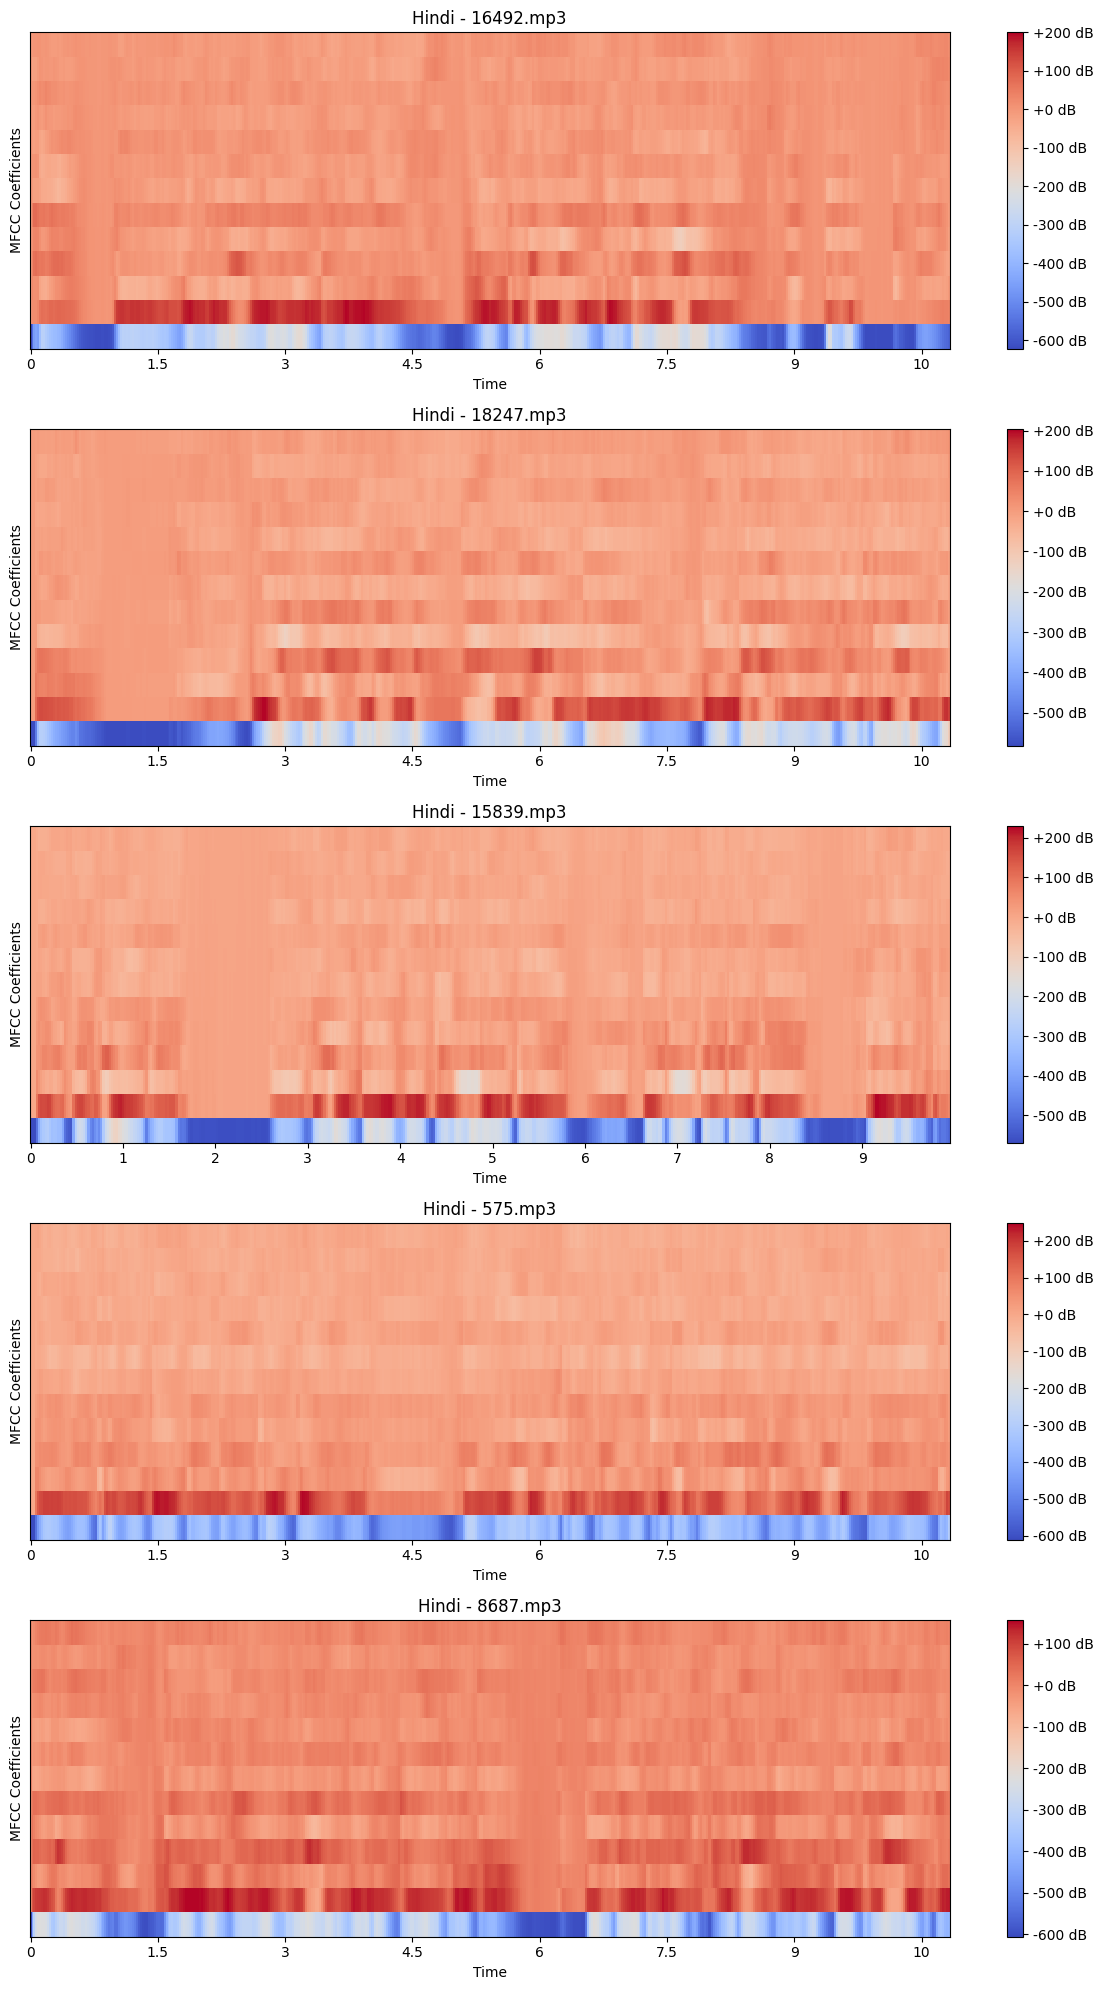

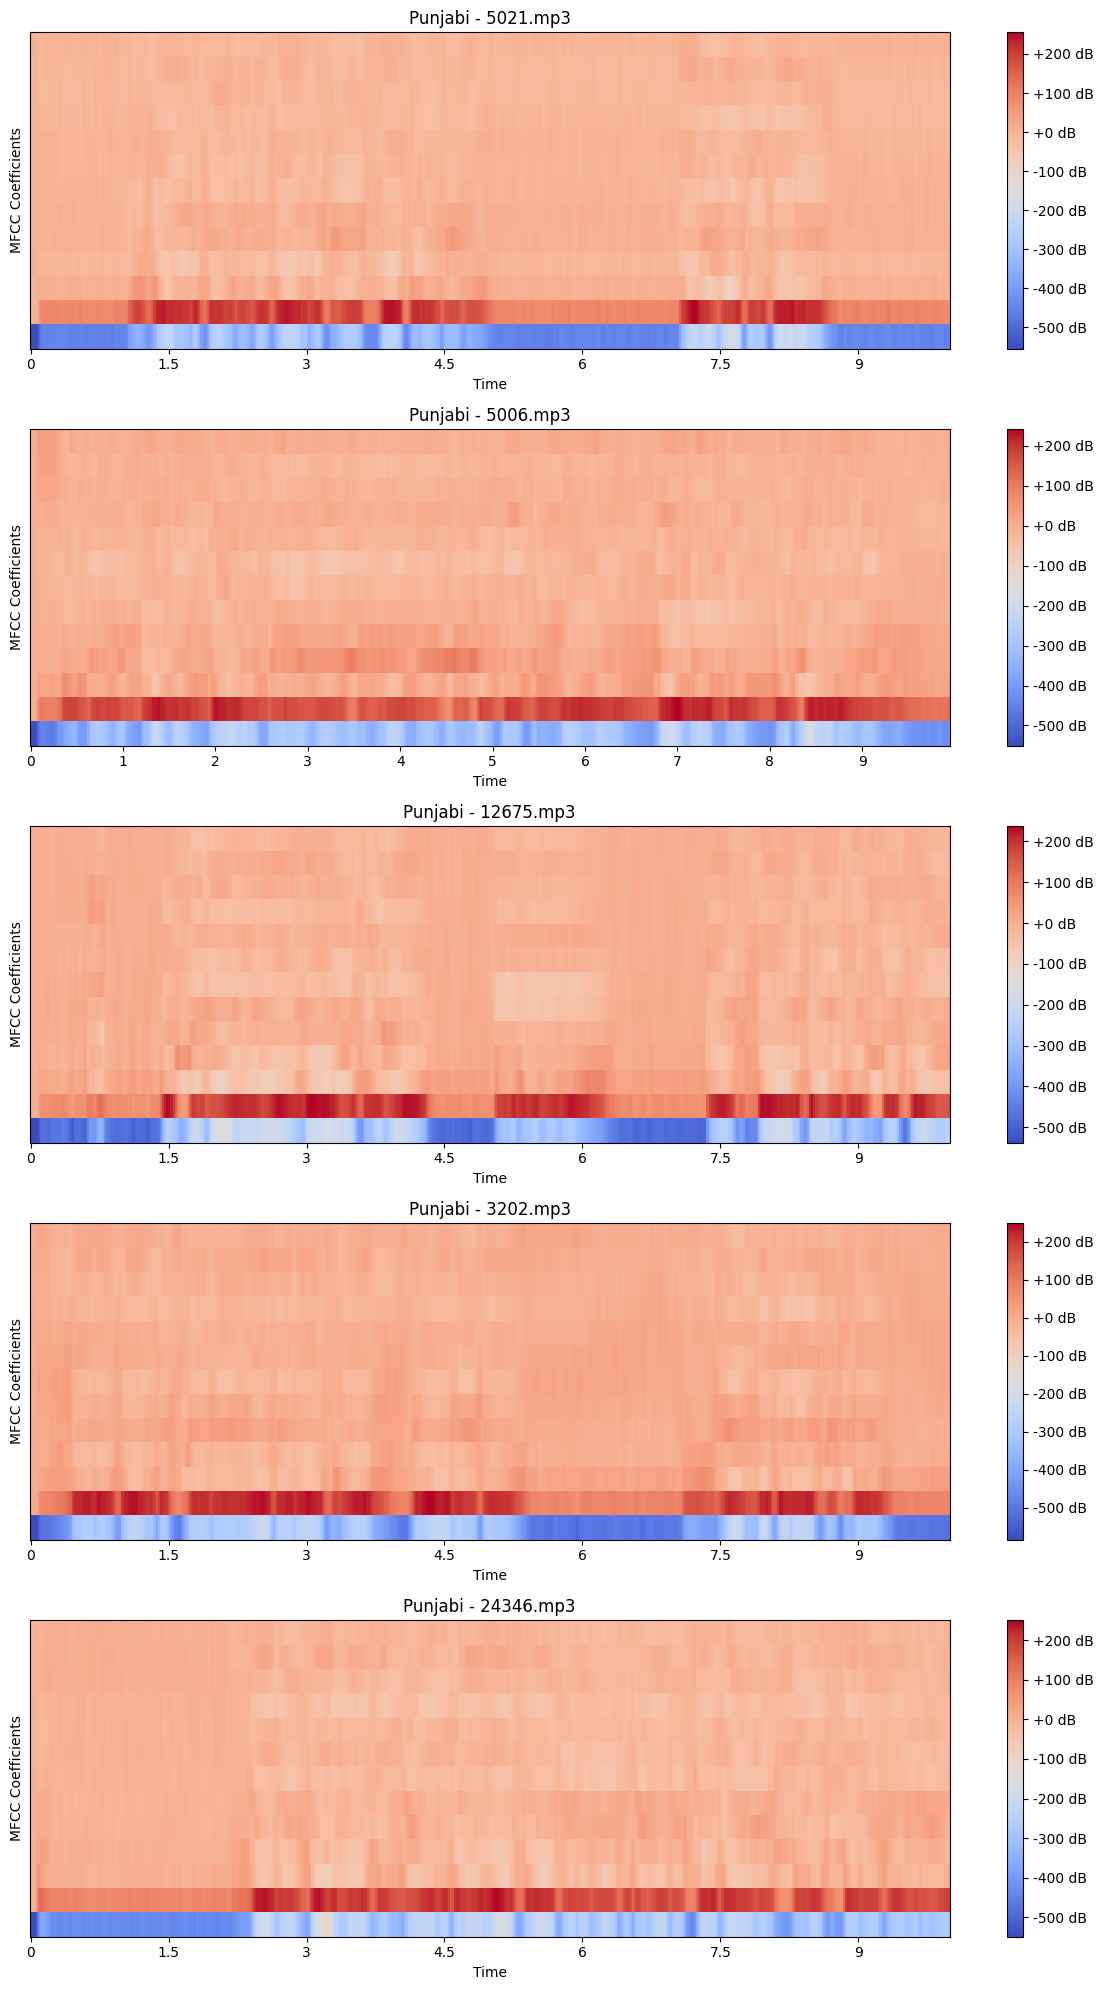

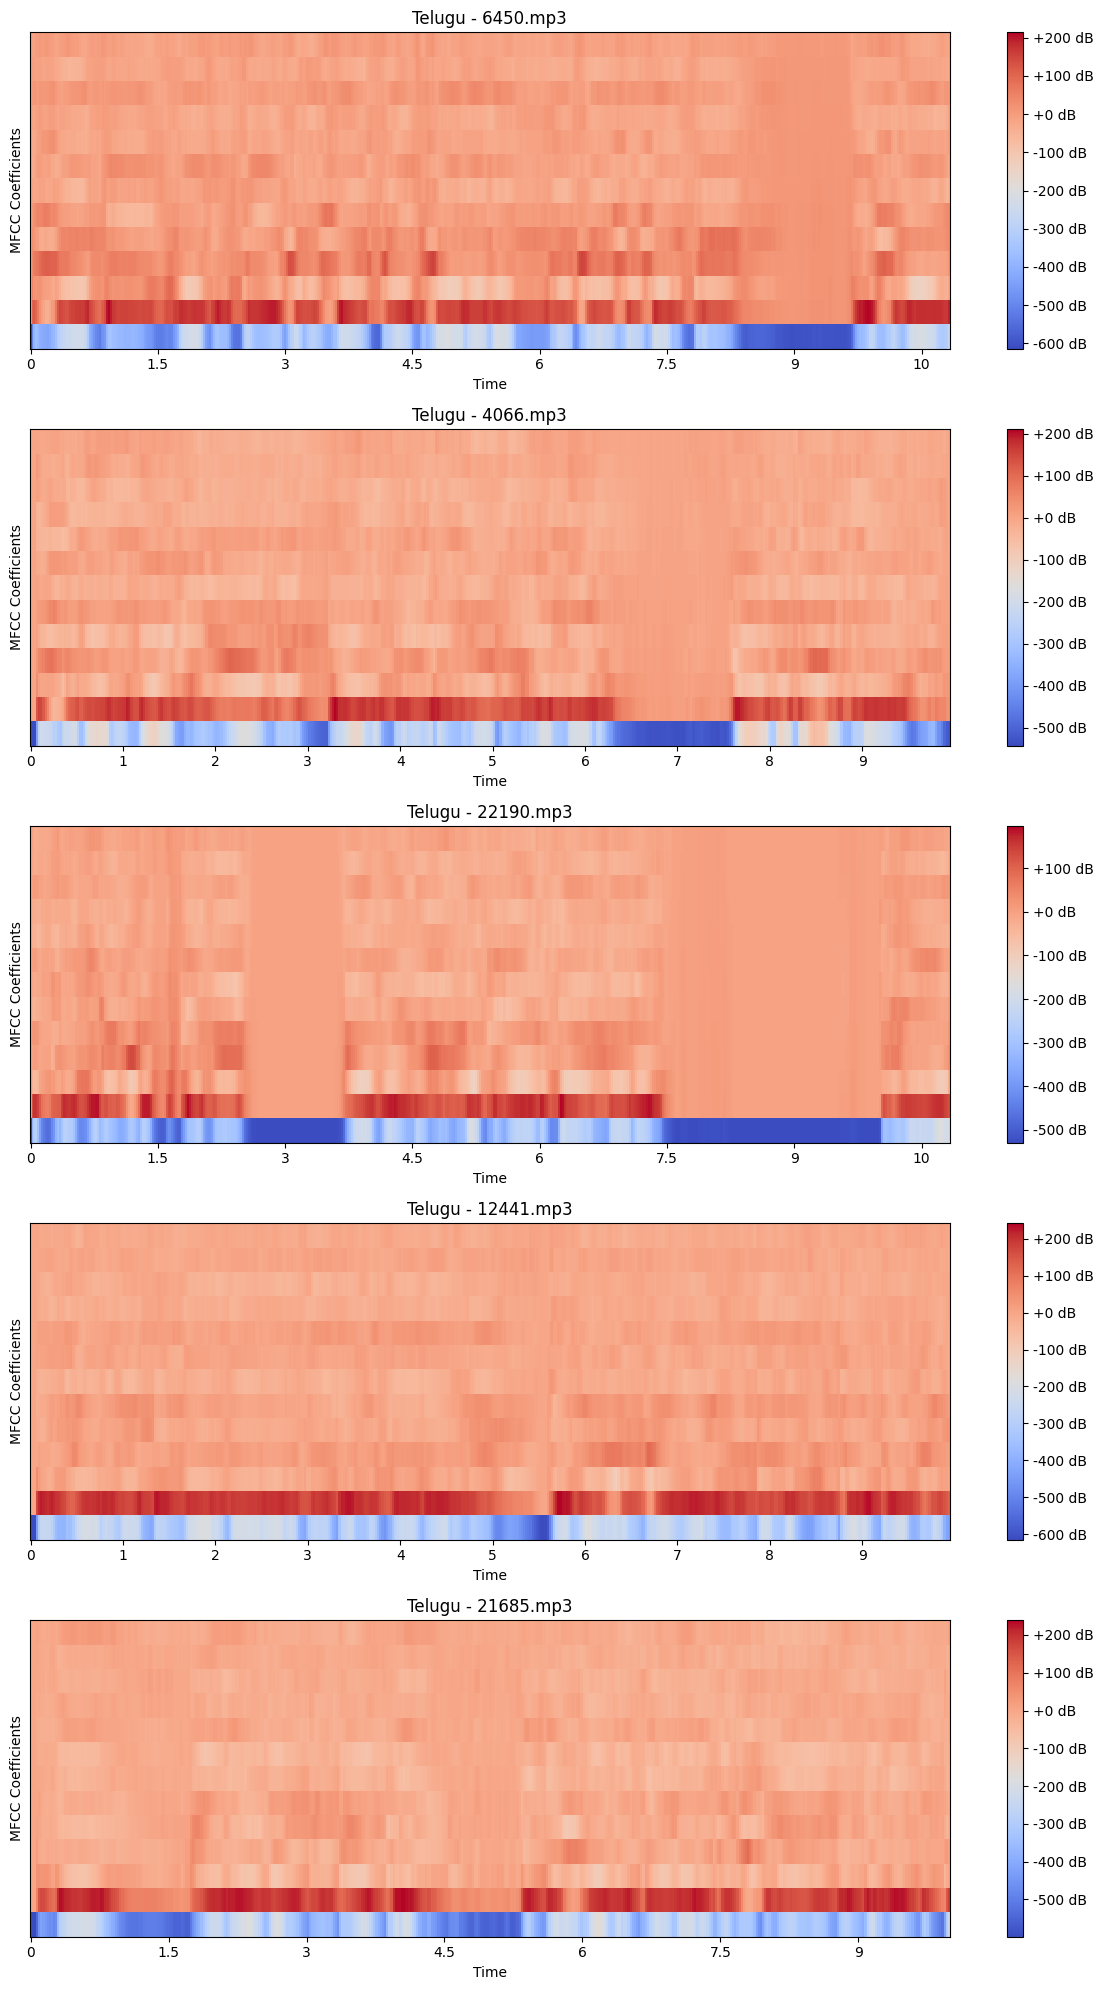

In [6]:
def visualize_mfccs(mfccs_by_language, file_paths_by_language, selected_languages):
    for language in selected_languages:
        mfccs_list = mfccs_by_language[language]
        file_paths = file_paths_by_language[language]
        
        fig, axes = plt.subplots(len(mfccs_list), 1, figsize=(12, 4 * len(mfccs_list)))
        
        if len(mfccs_list) == 1:
            axes = [axes]
        
        for i, (mfccs, file_path) in enumerate(zip(mfccs_list, file_paths)):
            filename = os.path.basename(file_path)
            librosa.display.specshow(mfccs, sr=22050, x_axis='time', ax=axes[i])
            axes[i].set_title(f'{language} - {filename}')
            axes[i].set_ylabel('MFCC Coefficients')
            fig.colorbar(axes[i].collections[0], ax=axes[i], format='%+2.0f dB')
        
        plt.tight_layout()
        plt.savefig(f'{language}_mfcc_spectrograms.png')
        plt.show()

visualize_mfccs(selected_mfccs, selected_file_paths, selected_languages)

In [7]:
def compute_mfcc_stats(mfccs_by_language):
    statistics = []

    for language, mfccs_list in mfccs_by_language.items():
        if not mfccs_list:
            continue

        all_mfccs = np.concatenate(mfccs_list, axis=1)

        for i in range(all_mfccs.shape[0]):
            coef = all_mfccs[i, :]
            stats = {
                'Language': language,
                'MFCC_Coefficient': i,
                'Mean': np.mean(coef),
                'Std': np.std(coef),
                'Variance': np.var(coef),
                'Min': np.min(coef),
                'Max': np.max(coef),
                'Median': np.median(coef)
            }
            statistics.append(stats)

    return pd.DataFrame(statistics)


mfcc_statistics = compute_mfcc_stats(all_mfccs)


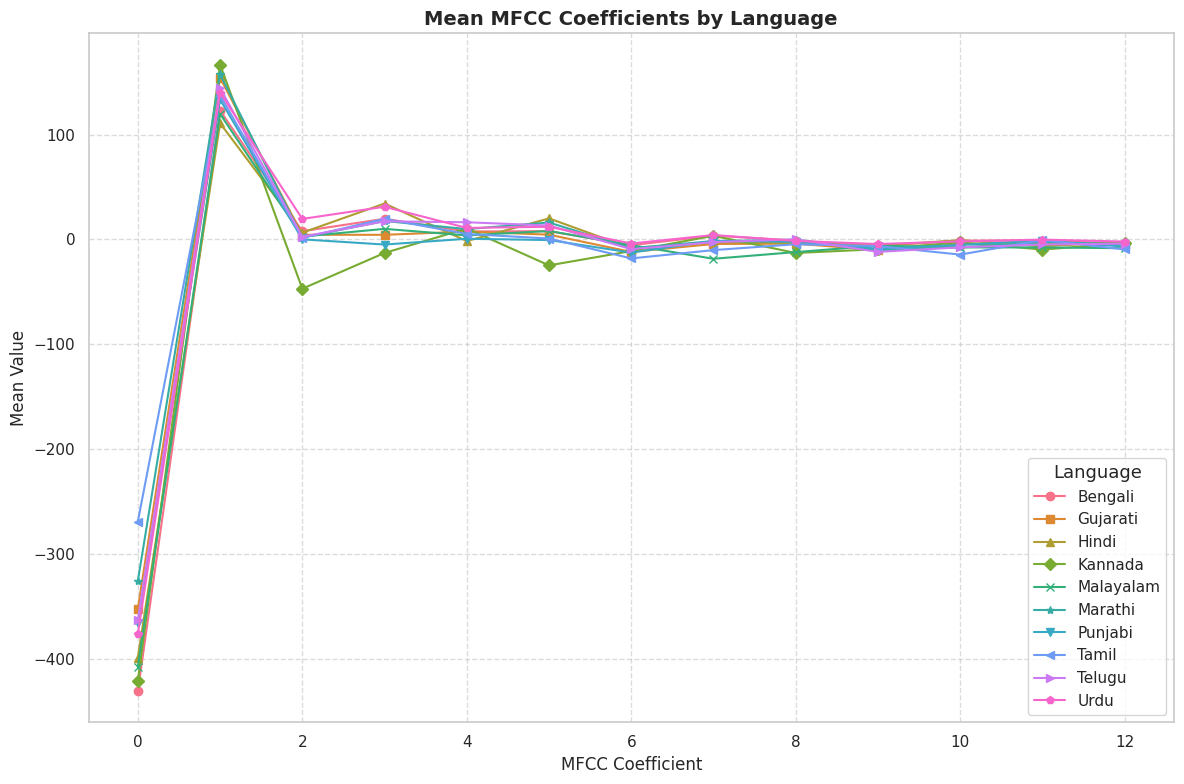

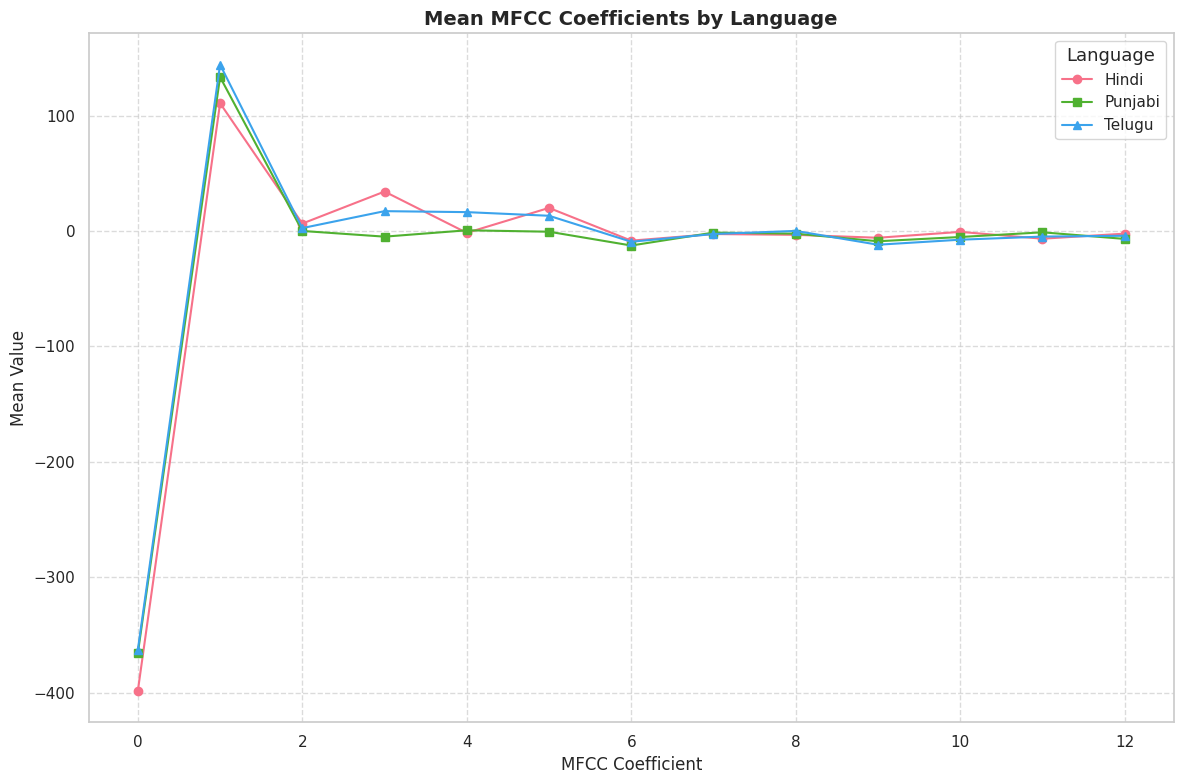

In [15]:
sns.set_theme(style="whitegrid")

def plot_mean_mfccs(statistics_df, selected_languages=None):
    
    if selected_languages:
        df = statistics_df[statistics_df['Language'].isin(selected_languages)]
    else:
        df = statistics_df
    
    plt.figure(figsize=(12, 8))
    
    
    markers = ['o', 's', '^', 'D', 'x', '*', 'v', '<', '>', 'p']
    color_palette = sns.color_palette('husl', len(df['Language'].unique()))

    for idx, language in enumerate(df['Language'].unique()):
        language_stats = df[df['Language'] == language]
        

        marker = markers[idx % len(markers)]
        plt.plot(
            language_stats['MFCC_Coefficient'],
            language_stats['Mean'],
            marker=marker,
            linestyle='-',
            label=language,
            color=color_palette[idx % len(color_palette)]
        )

    plt.title('Mean MFCC Coefficients by Language', fontsize=14, fontweight='bold')
    plt.xlabel('MFCC Coefficient', fontsize=12)
    plt.ylabel('Mean Value', fontsize=12)
    plt.legend(title="Language", title_fontsize='13', fontsize='11')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    
    plt.savefig('mean_mfcc_comparison_enhanced.png')
    plt.show()

plot_mean_mfccs(mfcc_statistics)

plot_mean_mfccs(mfcc_statistics, selected_languages)


In [9]:
def plot_variance_mfccs(statistics_df, selected_languages=None):
    if selected_languages:
        df = statistics_df[statistics_df['Language'].isin(selected_languages)]
    else:
        df = statistics_df

    plt.figure(figsize=(12, 8))

    for language in df['Language'].unique():
        language_stats = df[df['Language'] == language]
        plt.plot(
            language_stats['MFCC_Coefficient'],
            language_stats['Variance'],
            marker='o',
            linestyle='--',
            label=language
        )

    plt.title('Variance of MFCC Coefficients by Language')
    plt.xlabel('MFCC Coefficient')
    plt.ylabel('Variance Value')
    plt.legend()
    plt.grid(True)
    plt.savefig('variance_mfcc_comparison.png')
    plt.show()


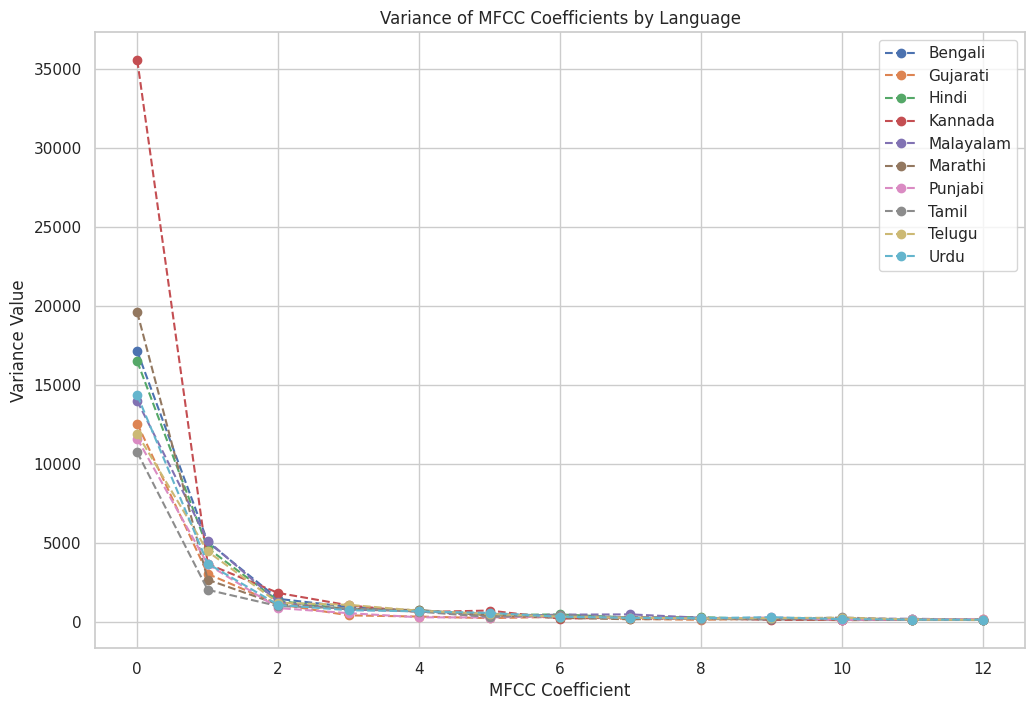

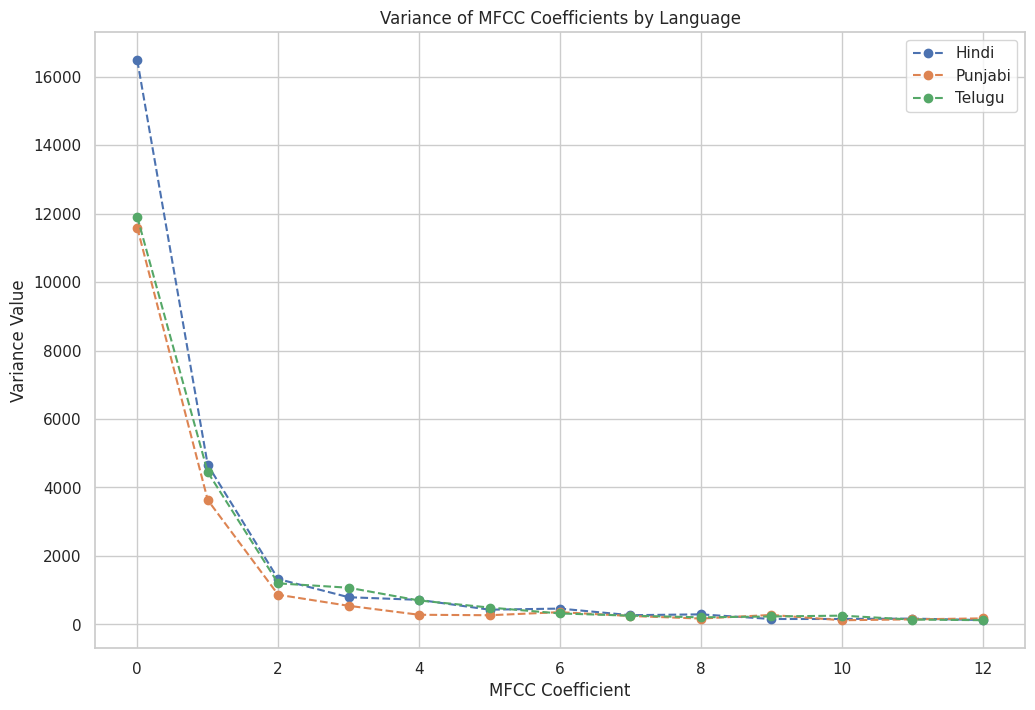

In [16]:
plot_variance_mfccs(mfcc_statistics)

plot_variance_mfccs(mfcc_statistics, selected_languages)

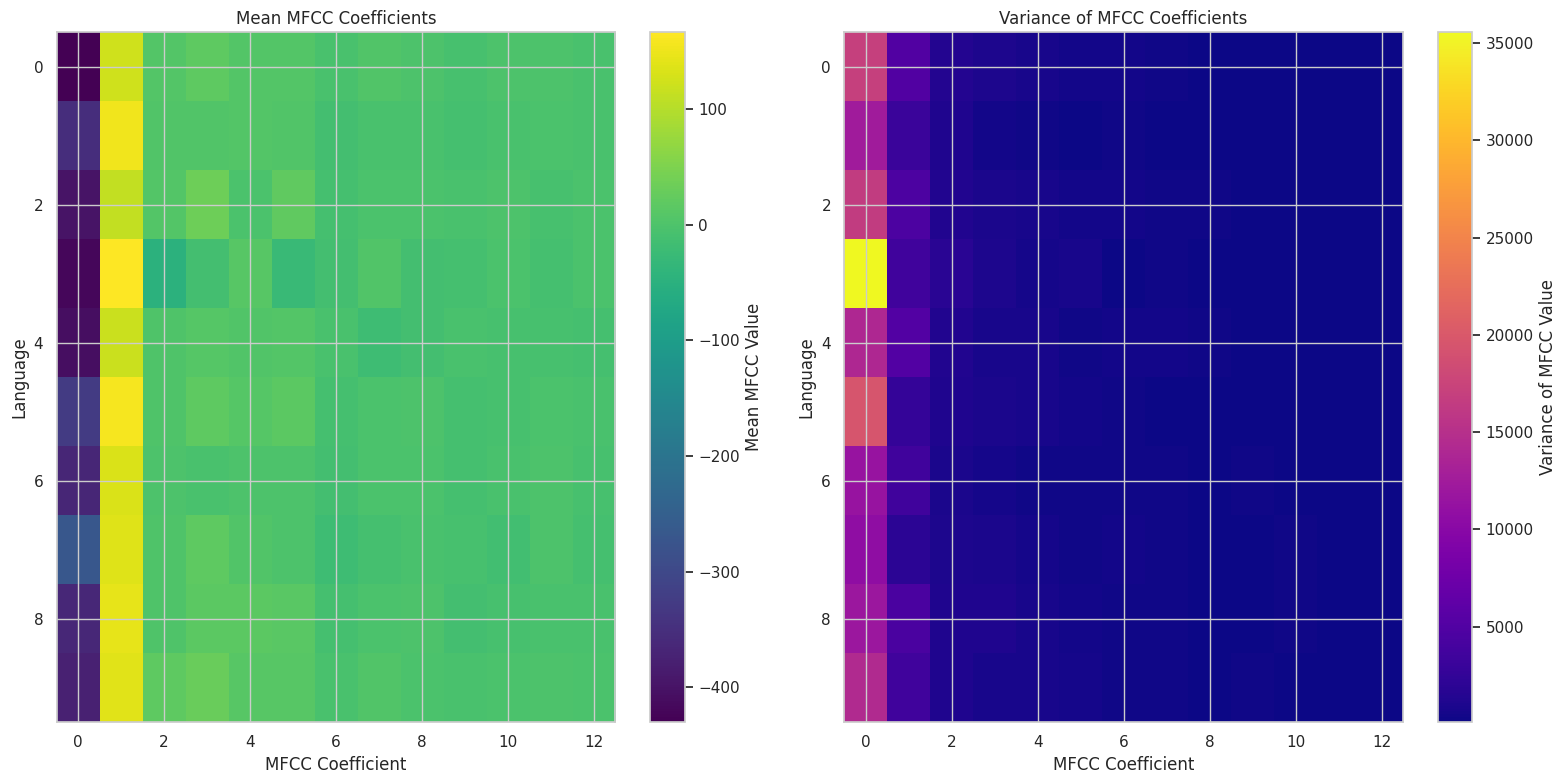

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))


pivot_mean = mfcc_statistics.pivot_table(index='Language', columns='MFCC_Coefficient', values='Mean')
im1 = axes[0].imshow(pivot_mean, aspect='auto', cmap='viridis')
axes[0].set_title('Mean MFCC Coefficients')
axes[0].set_xlabel('MFCC Coefficient')
axes[0].set_ylabel('Language')
fig.colorbar(im1, ax=axes[0], label='Mean MFCC Value')

# Variance Heatmap
pivot_variance = mfcc_statistics.pivot_table(index='Language', columns='MFCC_Coefficient', values='Variance')
im2 = axes[1].imshow(pivot_variance, aspect='auto', cmap='plasma')
axes[1].set_title('Variance of MFCC Coefficients')
axes[1].set_xlabel('MFCC Coefficient')
axes[1].set_ylabel('Language')
fig.colorbar(im2, ax=axes[1], label='Variance of MFCC Value')

plt.tight_layout()
plt.savefig('mfcc_mean_variance_heatmaps.png')
plt.show()


# Task 2


In [18]:
def prepare_data_for_classification(mfccs_by_language):
    
    X = []
    y = []
    language_mapping = {}
    
    for i, (language, mfccs_list) in enumerate(mfccs_by_language.items()):
        language_mapping[i] = language
        
        for mfccs in mfccs_list:
            mfcc_mean = np.mean(mfccs, axis=1)
            mfcc_std = np.std(mfccs, axis=1)
            
            features = np.concatenate([mfcc_mean, mfcc_std])
            
            X.append(features)
            y.append(i)
    
    return np.array(X), np.array(y), language_mapping

In [19]:
def build_random_forest_classifier(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestClassifier(n_estimators=100, random_state=random_state)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    return model, scaler, accuracy, report, conf_matrix, (X_train, X_test, y_train, y_test)


In [20]:
def plot_confusion_matrix(conf_matrix, language_mapping):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=[language_mapping[i] for i in range(len(language_mapping))],
        yticklabels=[language_mapping[i] for i in range(len(language_mapping))]
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

In [21]:
def analyze_feature_importance(model):

    n_features = len(model.feature_importances_) // 2
    
    mean_importances = model.feature_importances_[:n_features]
    std_importances = model.feature_importances_[n_features:]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(n_features), mean_importances)
    plt.title('Feature Importance: MFCC Means')
    plt.xlabel('MFCC Coefficient')
    plt.ylabel('Importance')
    
    plt.subplot(1, 2, 2)
    plt.bar(range(n_features), std_importances)
    plt.title('Feature Importance: MFCC Standard Deviations')
    plt.xlabel('MFCC Coefficient')
    plt.ylabel('Importance')
    
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()


In [22]:
def predict_language(model, scaler, file_path, language_mapping, n_mfcc=13):
    
    mfccs = extract_mfcc(file_path, n_mfcc)
    
    if mfccs is None:
        return "Error processing audio file"
    
    mfcc_mean = np.mean(mfccs, axis=1)
    mfcc_std = np.std(mfccs, axis=1)
    
    features = np.concatenate([mfcc_mean, mfcc_std]).reshape(1, -1)
    
    features_scaled = scaler.transform(features)
    
    prediction = model.predict(features_scaled)[0]
    
    return language_mapping[prediction]

Extracted MFCCs for 10 languages
Preparing data for classification...
Feature matrix shape: (10000, 26)
Number of classes: 10
Languages: ['Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Malayalam', 'Marathi', 'Punjabi', 'Tamil', 'Telugu', 'Urdu']

Building and evaluating Random Forest classifier...
Random Forest Accuracy: 0.8480
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       200
           1       0.49      0.53      0.50       200
           2       0.93      0.98      0.96       200
           3       0.99      0.89      0.94       200
           4       0.92      0.97      0.94       200
           5       0.95      0.89      0.92       200
           6       0.48      0.45      0.47       200
           7       0.97      0.97      0.97       200
           8       0.99      0.95      0.97       200
           9       0.87      0.92      0.90       200

    accuracy                           0.85      2000


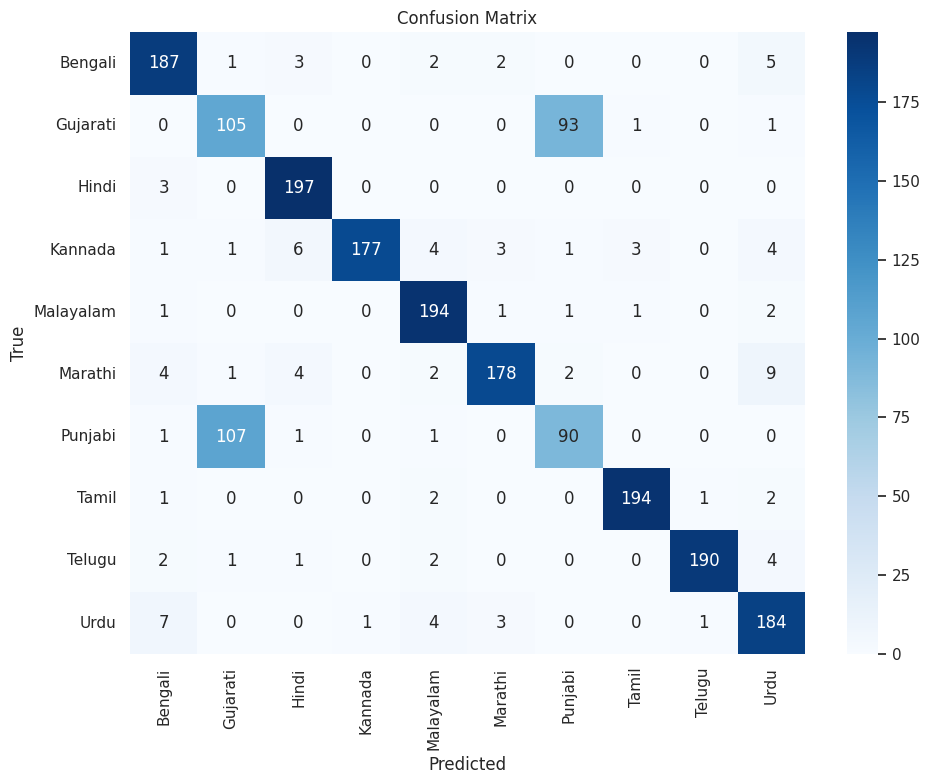


Analyzing feature importance...


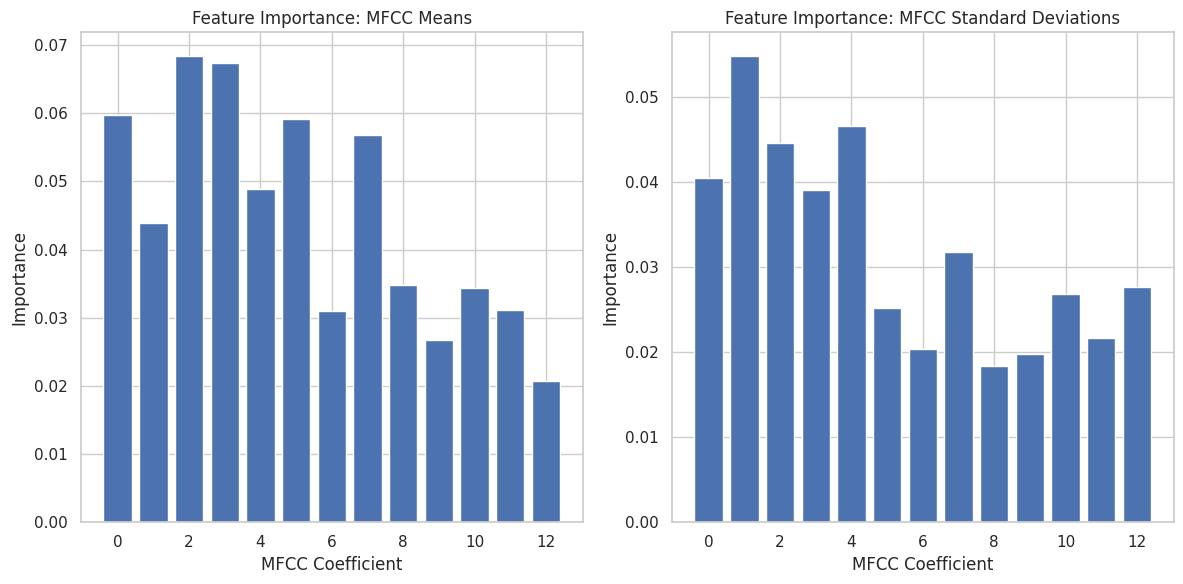

In [23]:
all_mfccs, all_file_paths = extract_mfccs_for_languages(languages, samples_per_language=1000)
print(f"Extracted MFCCs for {len(languages)} languages")

print("Preparing data for classification...")
X, y, language_mapping = prepare_data_for_classification(all_mfccs)
print(f"Feature matrix shape: {X.shape}")
print(f"Number of classes: {len(language_mapping)}")
print(f"Languages: {[language_mapping[i] for i in range(len(language_mapping))]}")

print("\nBuilding and evaluating Random Forest classifier...")
model, scaler, accuracy, report, confusion, (X_train, X_test, y_train, y_test) = build_random_forest_classifier(X, y)
print(f"Random Forest Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

print("\nPlotting confusion matrix...")
plot_confusion_matrix(confusion, language_mapping)

print("\nAnalyzing feature importance...")
analyze_feature_importance(model)

In [29]:
print("Testing prediction with a sample audio file")
sample_file_path = list(all_file_paths.values())[5][0]  
predicted_language = predict_language(model, scaler, sample_file_path, language_mapping)
print(f"Sample file: {sample_file_path}")
print(f"Predicted language: {predicted_language}")


Testing prediction with a sample audio file
Sample file: /kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Marathi/13127.mp3
Predicted language: Marathi
